# Salary Analysis of various US States


***
Created on Oct 25, 2017  
Last updated  
@author: Aamir
***

## Background

In the spirit of public transparency, states publish the compensation for all state employees (as a random sample, here are ones for Illinois, Rhode Island, California, Washington State). From this dataset some of the interesting questions that can be answered are:  
- Which public sector professions or geographies pay better?  
- How much would salaries increase over time?  
- How does this vary by state?  
- Can we correlate teacher pay with school ratings or hospital performance?  
- Does university professor pay track with the prestige of their publication record?

## Data Extraction and Cleaning

### Import Libraries

In [1]:
%matplotlib inline
import os
import io
import glob
import scipy.io
import numpy as np
import pandas as pd
from math import log10, floor
from datetime import datetime

from IPython.display import SVG
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14,9]

import csv
import certifi
import requests
import urllib.request
import ssl
from bs4 import BeautifulSoup


In [2]:
# fix random seed for reproducibility
np.random.seed(7)
os.chdir("./datasets")

### Web Scraping

ONLY ONE TIME PROCESSING

In [ ]:
# Scrap the URLs
listingURL = "https://transparentcalifornia.com/agencies/salaries/"
context = ssl._create_unverified_context()
response = urllib.request.urlopen(listingURL,context=context).read()
soup = BeautifulSoup(response, "html.parser")
p = []
weblinks = soup.find_all('a')
for link in weblinks:
    p.append(link.get('href'))
scrap_links = pd.DataFrame(p)

In [ ]:
# Clean the links
df = scrap_links[scrap_links[0].str.startswith("/salaries")]
df = df[0].str.extract('(?P<year>\d{4})/(?P<name>[a-z\-]+)',expand=False)
df = df.dropna()
df = df.reset_index()
df_links = pd.DataFrame('https://transparentcalifornia.com/export/' + df.name + '-' + df.year + '.csv')

In [ ]:
# Download all csv files
context = ssl._create_unverified_context()
for d in range(0, len(df_links)):
    download_url = df_links[0][d]
    download_name = df.name[d] + '-' + df.year[d] + ".csv"
    #print(d, download_name, download_url)
    x = urllib.request.urlopen(download_url,context=context)
    p = pd.DataFrame(pd.read_csv(io.StringIO(x.read().decode("ISO-8859-1"))))
    p.to_csv(download_name, encoding = "ISO-8859-1", index=False)
print("Total CSV files download = ", len(df_links))

### Import and merge data 

In [3]:
os.getcwd()

'D:\\Workspace\\Python\\Incubator-Project\\salaries\\datasets'

In [4]:
all_files = glob.glob(os.path.join(os.getcwd(), "*.csv"))
df_from_each_file = (pd.read_csv(f,encoding="ISO-8859-1",dtype=object) for f in all_files)
cal_data = pd.concat(df_from_each_file, ignore_index=True)


In [5]:
cal_data.shape

(8219505, 23)

In [6]:
cal_data.dtypes

Agency                  object
Base Pay                object
Benefits                object
Employee Name           object
Job Title               object
Notes                   object
Other Pay               object
Overtime Pay            object
Status                  object
Total Pay               object
Total Pay & Benefits    object
Year                    object
base_pay                object
employee_name           object
job_title               object
jurisdiction_name       object
notes                   object
other_pay               object
overtime_pay            object
total_benefits          object
total_pay               object
total_pay_benefits      object
year                    object
dtype: object

### Cleaning Data

Merge similar columns

In [7]:
cal_data['Agency'].fillna(cal_data['jurisdiction_name'], inplace=True)
cal_data['Base Pay'].fillna(cal_data['base_pay'], inplace=True)
cal_data['Benefits'].fillna(cal_data['total_benefits'], inplace=True)
cal_data['Employee Name'].fillna(cal_data['employee_name'], inplace=True)
cal_data['Job Title'].fillna(cal_data['job_title'], inplace=True)
cal_data['Notes'].fillna(cal_data['notes'], inplace=True)
cal_data['Other Pay'].fillna(cal_data['other_pay'], inplace=True)
cal_data['Overtime Pay'].fillna(cal_data['overtime_pay'], inplace=True)
cal_data['Total Pay'].fillna(cal_data['total_pay'], inplace=True)
cal_data['Total Pay & Benefits'].fillna(cal_data['total_pay_benefits'], inplace=True)
cal_data['Year'].fillna(cal_data['year'], inplace=True)


In [8]:
columns = ['base_pay','employee_name','job_title','jurisdiction_name','notes','other_pay','overtime_pay','total_benefits','total_pay','total_pay_benefits','year']
cal_data.drop(columns, inplace=True, axis=1)
cal_data.columns = ['Agency','BasePay','Benefits','EmployeeName','JobTitle','Notes','OtherPay','OvertimePay','Status','TotalPay','TotalPayBenefits','Year']

Enforce column datatypes

In [9]:
cal_data.Agency = cal_data.Agency.astype(str)
cal_data.BasePay = pd.to_numeric(cal_data.BasePay,errors='coerce')
cal_data.Benefits = pd.to_numeric(cal_data.Benefits,errors='coerce')
cal_data.EmployeeName = cal_data.EmployeeName.astype(str)
cal_data.JobTitle = cal_data.JobTitle.astype(str)
cal_data.Notes = cal_data.Notes.astype(str)
cal_data.OvertimePay = pd.to_numeric(cal_data.OvertimePay,errors='coerce')
cal_data.Status = cal_data.Status.astype(str)
cal_data.TotalPay = pd.to_numeric(cal_data.TotalPay,errors='coerce')
cal_data.TotalPayBenefits = pd.to_numeric(cal_data.TotalPayBenefits,errors='coerce')
cal_data.Year = cal_data.Year.astype(int)

In [10]:
cal_data = cal_data.drop_duplicates()
cal_data = cal_data.reset_index()

In [11]:
cal_data.index

RangeIndex(start=0, stop=8011690, step=1)

In [13]:
np.sum(cal_data.isnull())

index                     0
Agency                    0
BasePay               13852
Benefits            1188005
EmployeeName              0
JobTitle                  0
Notes                     0
OtherPay              34956
OvertimePay           30499
Status                    0
TotalPay                 45
TotalPayBenefits          0
Year                      0
dtype: int64

In [14]:
cal_data.shape

(8011690, 13)

So, overall we have around 8 million unique employee salary data. 

In [30]:
cal_data.to_csv("../cal_data.csv",encoding="ISO-8859-1")

### Feature Engineering
**Cleaning Job Titles**  

Job titles are extremely unclean. It requires a huge effort to merge the similar job titles. Some of the initial steps in this direction could be:  
- Remove differing case letters by converting all titles to upper (or lower) case.
- Converting Arabic numbers (1,2,3,...) to Roman numbers (I,II,III,...) whereever they exist.
- Try to remove special characters (&,!,# etc), commas, dots 
- Try to standardize the abbreviations like (Sr. for Senior), either choose the short form or the long form.
- Feature engineering, add a new column where more generalized column names are displayed (like developer for senior developer, junior developer, java developer etc.)



To observe improvements, we keep track of unique job titles

In [15]:
cal_data.JobTitle.describe()

count                      8011690
unique                      158309
top       LECTURER - ACADEMIC YEAR
freq                         96243
Name: JobTitle, dtype: object

**Make job title text uppercase to remove duplicates**

In [16]:
cal_data.JobTitle = cal_data.JobTitle.str.upper()

In [17]:
cal_data.JobTitle.describe()

count                      8011690
unique                      136769
top       LECTURER - ACADEMIC YEAR
freq                        112319
Name: JobTitle, dtype: object

The unique job titles has improved from 158k to 136k.

**Converting Arabic numbers (1,2,3,...) to Roman numbers (I,II,III,...)**

In [47]:
cal_data.JobTitle = cal_data.JobTitle.str.replace('1 ','I ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('2 ','II ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('3 ','III ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('4 ','IV ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('5 ','V ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('6 ','VI ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('7 ','VII ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('8 ','VIII ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('9 ','IX ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('10 ','X ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('11 ','XI ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('12 ','XII ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('13 ','XIII ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('14 ','XIV ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('15 ','XV ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('16 ','XVI ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('17 ','XVII ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('18 ','XVIII ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('19 ','XIX ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('20 ','XX ')

In [48]:
cal_data.JobTitle.describe()

count                      8011690
unique                      135762
top       LECTURER - ACADEMIC YEAR
freq                        112319
Name: JobTitle, dtype: object

**Try to remove special characters (&,!,# etc), commas, dots**

In [55]:
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\b&\b',' AND ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('!',' ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('#',' ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('*',' ')
cal_data.JobTitle = cal_data.JobTitle.str.replace(',',' ')
cal_data.JobTitle = cal_data.JobTitle.str.replace('.',' ')

In [56]:
cal_data.JobTitle.describe()

count     8011690
unique     131016
top        STDT  
freq       162804
Name: JobTitle, dtype: object

**Replace abbreviations with full titles**

In [58]:
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bMGR\b','MANAGER')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bMNGR\b','MANAGER')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bEMERG\b','EMERGENCY')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bCOORD\b','COORDINATOR')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bMAINT\b','MAINTENANCE')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSPRV\b','SUPERVISOR')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSUPV\b','SUPERVISOR')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSPEC\b','SPECIALIST')

cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSPEC\b','SPECIALIST')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bASST\b','ASSISTANT')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bAPRNTC\b','APPRENTICE')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSTATNRY\b','STATIONARY')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bENG\b','ENGINEER')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bENGR\b','ENGINEER')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSEW\b','SEWAGE')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bPLN\b','PLANT')

cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bMED\b','MEDICAL')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSVCS\b','SERVICE')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSERV\b','SERVICE')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bRNCH\b','RANCH')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bCLM\b','CLAIM')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bADMIN\b','ADMINISTRATOR')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bFAC\b','FACILITIES')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bCONST\b','CONSTRUCTION')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bMUSM\b','MUSEUM')

cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bCNSRVT\b','CONSERVATORY')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bAAM\b','ASIAN ART MUSEUM')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bCHF\b','CHIEF')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bDIST\b','DISTRICT')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bATTY\'S\b','ATTORNEY\'S')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bATTY\b','ATTORNEY')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bINVSTGTR\b','INVESTIGATOR')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bDEPT\b','DEPARTMENT')

cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bPROB\b','PROBATION')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bOFC\b','OFFICE')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bBUR\b','BUREAU')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bMUNI\b','MUNICIPAL')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bJUV\b','JUVENILE')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bCLK\b','CLERK')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bDIR\b','DIRECTOR')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bWRK\b','WORK')

cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bDIST\b','DISTRIBUTION')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bCFDNTAL\b','CONFIDENTIAL')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSCTRY\b','SECRETARY')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bCOMM\b','COMMUNICATION')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bDEP\b','DEPUTY')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bADMIN\b','ADMINISTRATIVE')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bDIR\b','DIRECTOR')
cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bASSOC\b','ASSOCIATE')

cal_data.JobTitle = cal_data.JobTitle.str.replace(r'\bSTDT\b','STUDENT')

In [59]:
cal_data.JobTitle.describe()

count       8011690
unique       127395
top       STUDENT  
freq         162804
Name: JobTitle, dtype: object

**Create new column 'JobTitle2' with more generalized column names**

In [90]:
conditions = [
    cal_data.JobTitle.str.contains('LECTURER'),
    cal_data.JobTitle.str.contains('PROFESSOR'),
    cal_data.JobTitle.str.contains('STUDENT'),
    cal_data.JobTitle.str.contains('MANAGER'),
    cal_data.JobTitle.str.contains('COORDINATOR'),
    cal_data.JobTitle.str.contains('SUPERVISOR'),
    cal_data.JobTitle.str.contains('ASSISTANT'),
    cal_data.JobTitle.str.contains('ENGINEER'),
    cal_data.JobTitle.str.contains('ACCOUNTANT'),
    
    cal_data.JobTitle.str.contains('CLERK'),
    cal_data.JobTitle.str.contains('TECHNICIAN'),
    cal_data.JobTitle.str.contains('NURSE'),
    cal_data.JobTitle.str.contains('NURSING'),
    cal_data.JobTitle.str.contains('INSTRUCTOR'),
    cal_data.JobTitle.str.contains('SECRETARY'),
    cal_data.JobTitle.str.contains('ANALYST'),
    cal_data.JobTitle.str.contains('LABORER'),
    cal_data.JobTitle.str.contains('WORKER'),
    cal_data.JobTitle.str.contains('INTERN')
]

choices = ['LECTURER','PROFESSOR','STUDENT','MANAGER','COORDINATOR',
           'SUPERVISOR','ASSISTANT','ENGINEER','ACCOUNTANT','CLERK',
           'TECHNICIAN','NURSE','NURSE','INSTRUCTOR','SECRETARY',
           'ANALYST','LABORER','WORKER','INTERN'
          ]

cal_data['JobTitle2'] = np.select(conditions,choices,default='')

In [91]:
cal_data.JobTitle2.describe()

count     8011690
unique         19
top              
freq      4364906
Name: JobTitle2, dtype: object

***
## Exploratory Data Analysis

### How much would salaries increase over time?

In [33]:
res1 = cal_data.TotalPayBenefits.groupby(cal_data.Year).mean()
res1

Year
2010    49336.948579
2011    65748.990915
2012    63143.383519
2013    71230.957928
2014    73581.074960
2015    76145.353455
2016    76615.576389
Name: TotalPayBenefits, dtype: float64

<Container object of 7 artists>

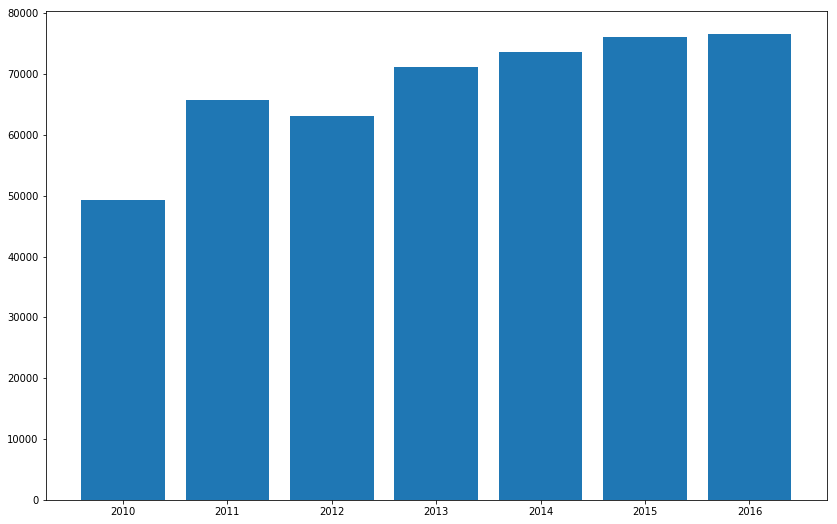

In [34]:
plt.bar(res.index,res.values)

That shows a huge increase from around \$50k to around \$75k in just six years. The graph above presents a rough idea, where all the professions are mixed together. Moreover, many people have extra benefits added to the total. 

To get a more clearer picture, lets see the **salary rise for Lecturers only.** Also ignore the other benefits.

In [136]:
res2 = cal_data[cal_data.JobTitle=="LECTURER - ACADEMIC YEAR"].TotalPay.groupby(cal_data.Year).mean()
res2

Year
2011    17662.098638
2012    16555.803332
2013    20586.010261
2014    20773.954978
2015    21512.364102
2016    19707.648663
Name: TotalPay, dtype: float64

<Container object of 6 artists>

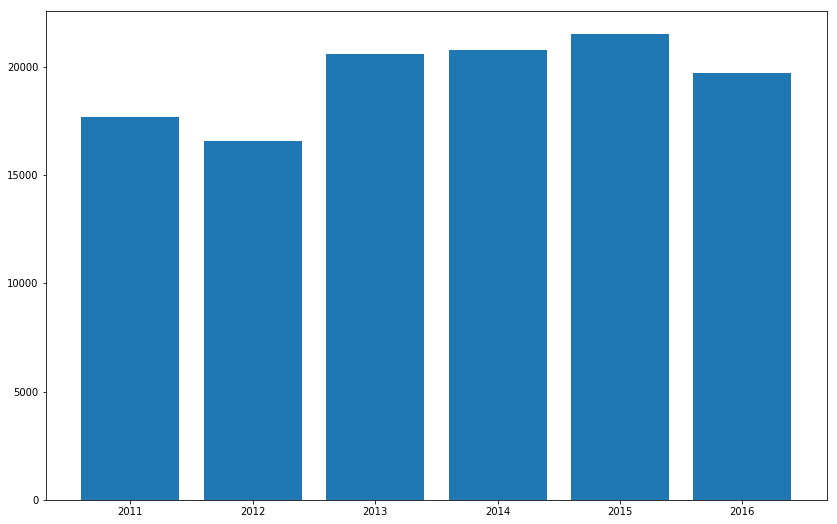

In [137]:
plt.bar(res2.index,res2.values)

So there definitely is considerable increase pattern in the salaries. But overall the lecturer salaries aren't increasing at the same pace with the other professions. This becomes more clearer when we move to the next question.

### Which public sector professions or geographies pay better?

We would analyze our data with the earlier separated job professions on per year basis. We will analyze the data through two different graphs.

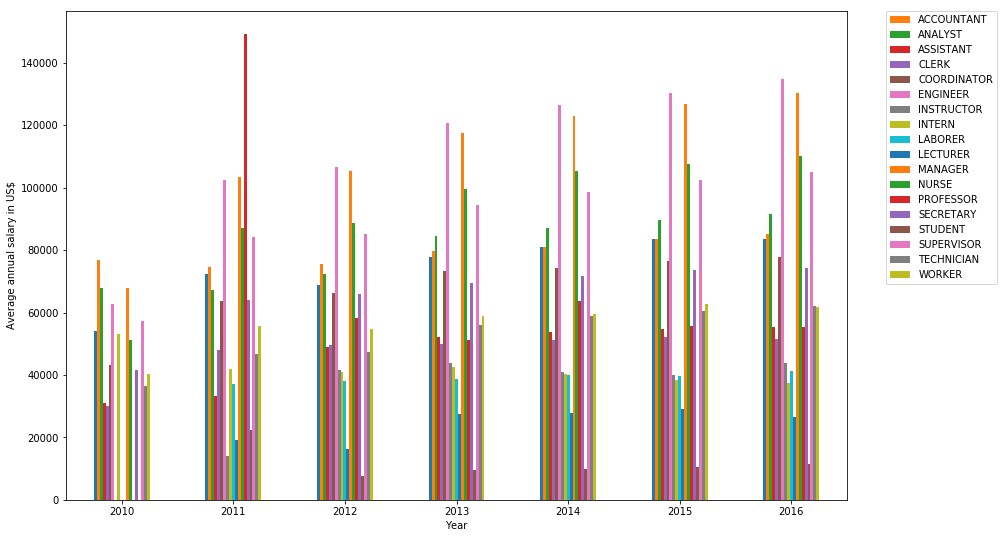

In [138]:
res3 = cal_data.groupby(['Year','JobTitle2'])['TotalPayBenefits'].mean()
plot_res3 = res3.unstack('JobTitle2').plot.bar(rot=0)
plt.ylabel('Average annual salary in US$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

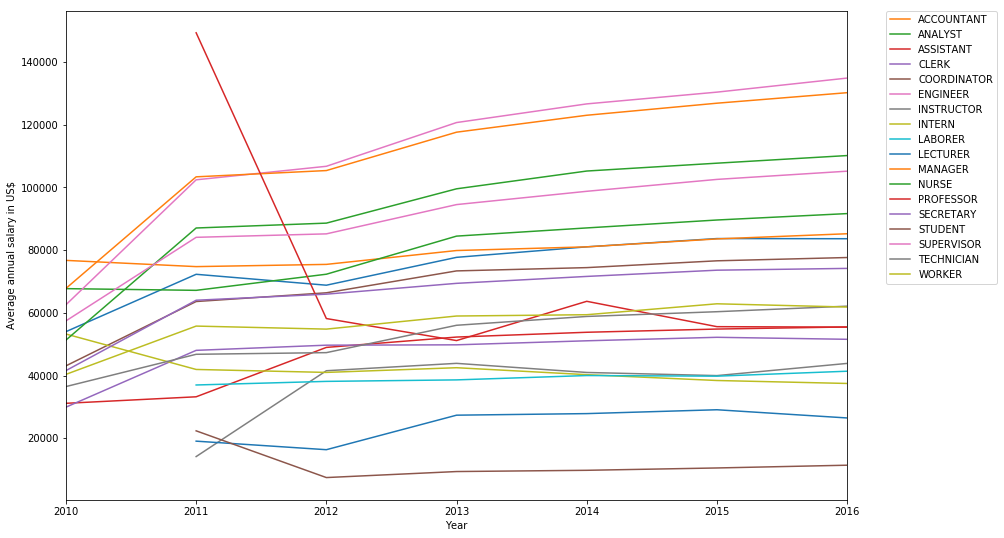

In [139]:
res3 = cal_data.groupby(['Year','JobTitle2'])['TotalPayBenefits'].mean()
plot_res3 = res3.unstack('JobTitle2').plot()
plt.ylabel('Average annual salary in US$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Here we see that the varying jobs have differing wage rates. By far, student jobs are the least paying ones followed by the lecturers who earn on average less than the laborers.  
The huge spike in the graph shows the differing earnings of the university professors over the years. It is quite an outlier behavior and needs further investigation.